# Post-Up EDA and Model
# EDA for Predictive Stats
In this notebook, I will explore the relationships of different player stats and their future rates and effectiveness in the selected categories (post-ups, drives, catch and shoot, and pull-ups.  

Goals:
- Create features based on previous years
- Look for what offensive stats might best predict offensive output

Conclusions:  
-

## 1. Importing Libraries and Data

In [107]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel, SelectKBest, RFECV, RFE, VarianceThreshold, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dictionaries import stat_types
from itertools import combinations

In [22]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 2. Feature Engingeering
#### Adding rate categories

In [23]:
# Creating rate columns for appropriate features
for column in stat_types['totals']:
    master_df[column + '_PER_MIN'] = master_df[column] / master_df['TOTAL_MIN']

for column in stat_types['game_totals']:
    master_df[column + '_PER_MIN'] = master_df[column] / master_df['MIN']

In [24]:
# Creating height to weight ratio
master_df['SKINNY'] = master_df['PLAYER_HEIGHT_INCHES'] / master_df['PLAYER_WEIGHT']

In [25]:
# Creating percent of post-ups that end in a shot
master_df['POST_TOUCH_FGA_PCT'] = master_df['POST_TOUCH_FGA'] / master_df['POST_TOUCHES']

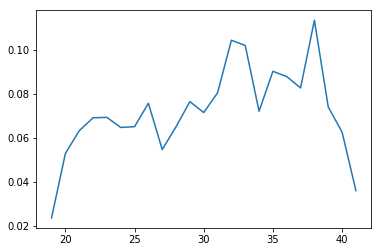

In [26]:
plt.plot(data.set_index('AGE')[['POST_TOUCH_EV', 'POST_TOUCH_RATE']].product(axis=1).groupby('AGE').mean());

## 2. Create Train, Validate, and Test Sets
#### Create X and y

In [27]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['POST_TOUCHES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [28]:
# Function to get future or past data for a player
def shift_data(df, on, columns, prefix='TARGET_', how=None, amount=1):
    
    # Create a copy of the df so as to not mess with the original df
    new_df = df.copy()
        
    # If no specific method is used
    if how == None:
        
        # For each value, filter the df and shift the columns the specified amount
        for value in df[on].unique():
            index = df[df[on]==value].index
            
            for column in columns:
                new_df.loc[index, prefix+column] = df.loc[index, column].shift(amount)
    
    return new_df

In [29]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['POST_TOUCH_EV'])

In [30]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_POST_TOUCH_EV']]
X = data.drop(columns='TARGET_POST_TOUCH_EV')

#### Splitting X and y into train, validate, and test sets

In [31]:
def data_split(X, y, category, test_size=.2, validate_size=.2):

    # Dropping players that don't have a target
    drop_index = y[y['TARGET_' + category].isna()].index
    y.drop(drop_index, inplace=True)
    X.drop(drop_index, inplace=True)
    
    # Dropping the rows when the player has NANs for that category in the current season
    X = X[~X[category].isna()]
    index = X.index
    y = y.loc[index]
    
    # Determining what to set 'test_size' in the split for the validation set
    validate_size = validate_size/(1 - test_size)
    
    # Creating the train, validate, and test from X and y.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=validate_size)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [32]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'POST_TOUCH_EV')

In [33]:
# You should likely determine some minimum threshhold to remove players.
# For example, did they play fewer than 100 minutes in the season.
# It can be really small, but it should remove players that did not play

## 3. Post-Ups Expected Value EDA
### Determine Features Using Just the Previous Year

In [34]:
def corr_plots(X, y, columns, cols=3):

    n = len(columns)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(5*cols, 5*rows))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    for i, column in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        plt.scatter(X[column], y)
        plt.xlabel(column)
        plt.ylabel(y.name)

In [68]:
# Function for finding feautres highly correlated with the target
def corr_finder(X, y, cutoff, size=None):
    
    # Finding the numeric columns
    numeric_columns = X.select_dtypes(['float', 'int']).columns
    
    # Creating a df of correlations (rows are predictive features, columns are target features)
    df = pd.concat([X,y], axis=1).corr().loc[numeric_columns, y.columns]
    
    # Creating a blank features list
#     corr_features = []
        
    feature = y.columns[0]
    
    # Saving the better correlated predictive features
    corr_features = list(df[abs(df[feature]) > cutoff].abs().sort_values(feature, ascending=False).index)
    
    # Making sure the number of correlated features is not greater than the 'size'
    if size:
        if len(corr_features) > size:
            corr_features = corr_features[:size]
        
    return corr_features

In [76]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train, y_train, .25, 10)

In [80]:
def corr_plots(X, y, columns, cols=3):

    n = len(columns)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(5*cols, 5*rows))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    for i, column in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        plt.scatter(X[column], y)
        plt.xlabel(column)
        plt.ylabel(y.columns[0])
        
def box_plots(X, y, columns, cols=3):
    
    n = len(columns)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(5*cols, 5*rows))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    for i, column in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        sns.boxplot(x=column, y=y.name, data=X)
        plt.xlabel(column)
        plt.ylabel(y.columns[0]);

In [112]:
corr_features

['AST_TO',
 'FT_PCT',
 'PAINT_TOUCHES_PER_MIN',
 'PAINT_TOUCH_FGA_PER_MIN',
 'OREB_CHANCES_PER_MIN',
 'AST_ADJ_PER_MIN',
 'PAINT_TOUCH_TOV_PER_MIN',
 'AST_POINTS_CREATED_PER_MIN',
 'OPEN_FGA_PER_MIN',
 'PAINT_TOUCH_FGM_PER_MIN']

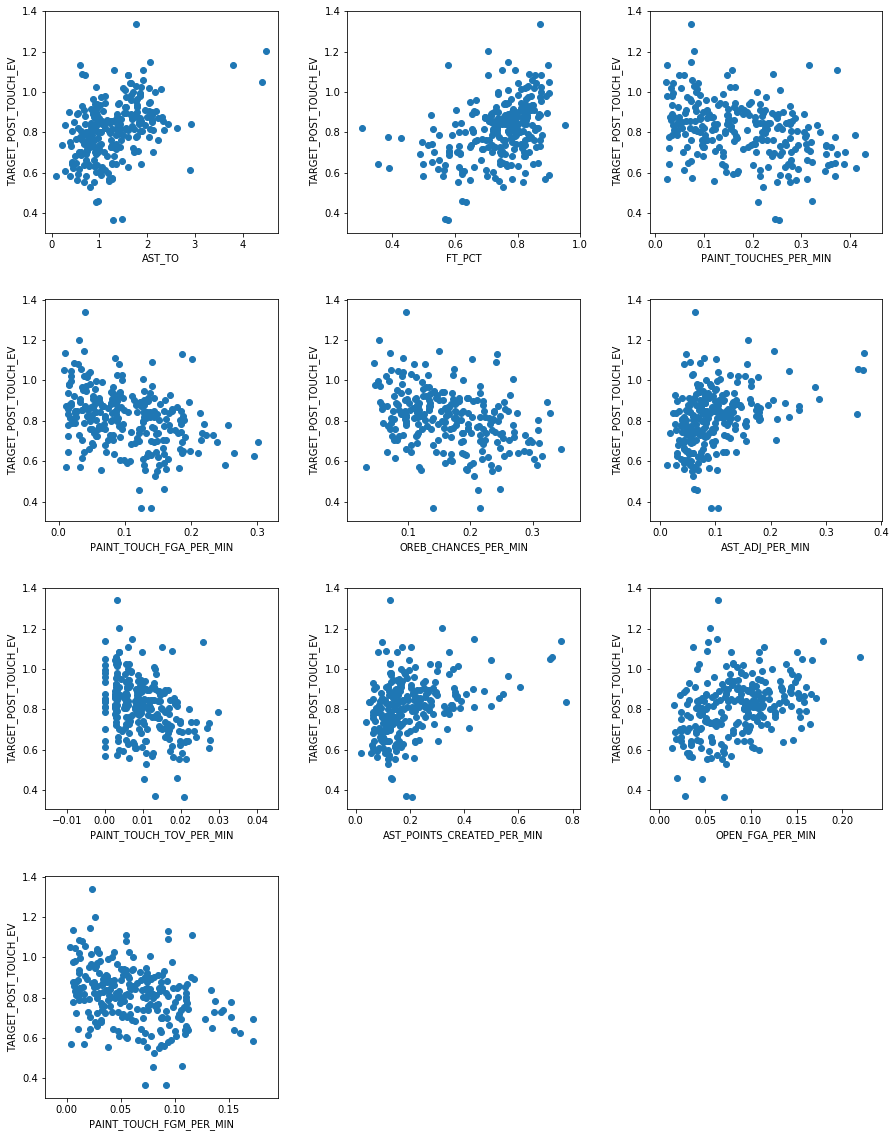

In [81]:
corr_plots(X_train, y_train, corr_features);

In [94]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train[corr_features])
X_validate_poly = poly.transform(X_validate[corr_features])

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_validate_scaled = scaler.transform(X_validate_poly)

In [102]:
ridge = Ridge()
kfolds = KFold(n_splits=5, shuffle=True)
param_grid = {
    'alpha': np.logspace(-1,3,100)
}
model = GridSearchCV(ridge, param_grid, cv=kfolds, verbose=1)
model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train), model.score(X_validate_scaled, y_validate)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.0s finished


(0.24325779101572076, 0.01187785641384631)

In [104]:
lasso = Lasso()
kfolds = KFold(n_splits=5, shuffle=True)
param_grid = {
    'alpha': np.linspace(0.01,1,100)
}
model = GridSearchCV(lasso, param_grid, cv=kfolds, verbose=1)
model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train), model.score(X_validate_scaled, y_validate)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.9s finished


(0.25331668187793466, 0.014059078326793206)

In [106]:
elastic = ElasticNet()
kfolds = KFold(n_splits=5, shuffle=True)
param_grid = {
    'alpha': np.logspace(-1,3,100),
    'l1_ratio': [.1, .5, .7, .9, .95, .99, 1]
}
model = GridSearchCV(elastic, param_grid, cv=kfolds, verbose=1)
model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train), model.score(X_validate_scaled, y_validate)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=1)]: Done 3500 out of 3500 | elapsed:    6.2s finished


(0.2514884001439247, 0.01807642363762585)

In [111]:
ada = AdaBoostRegressor()
kfolds = KFold(n_splits=5, shuffle=True)
param_grid = {
    'n_estimators': [10, 20, 50, 100],
}
model = GridSearchCV(ada, param_grid, cv=kfolds, verbose=1)
model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train), model.score(X_validate_scaled, y_validate)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

(0.6019095162957575, -0.2550915743418869)

In [115]:
model = LinearRegression()
cross_val_score(model, X_train[corr_features], y_train, cv=kfolds)

array([ 0.41135847,  0.1885663 ,  0.20094218, -0.01584757,  0.08753059])

In [120]:
model.fit(X_train[corr_features], y_train)
model.score(X_validate[corr_features], y_validate)

-0.05302227877936394

In [133]:
coefs = pd.DataFrame(abs(model.coef_[0]), index=corr_features).sort_values(0)

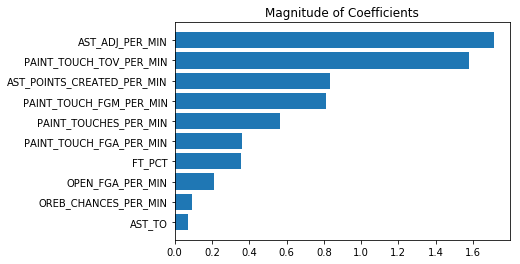

In [142]:
plt.barh(coefs.index, coefs[0])
plt.title('Magnitude of Coefficients');

There are too many strange data points. My wondering is that this is caused by players who took next to no post-up shots.

In [ ]:
# Looking at the number of players whose post-up rate or target post-up rate is less than .02
X_post_EV_train[(X_post_EV_train['POST_TOUCH_RATE']<.02)| (y_post_EV_train['TARGET_POST_TOUCH_RATE']<.02)].shape

In [ ]:
# Looking at how dropping those rows affects the distribution
drop_index = X_post_EV_train[(X_post_EV_train['POST_TOUCH_RATE']<.025) | 
                             (y_post_EV_train['TARGET_POST_TOUCH_RATE']<.025)].index
plt.scatter(X_post_EV_train.drop(index=drop_index)['POST_TOUCH_EV'],
            y_post_EV_train.drop(index=drop_index)['TARGET_POST_TOUCH_EV']);
plt.plot(np.linspace(0,2), np.linspace(0,2), color='r')
plt.xlabel('Post-Up Rate')
plt.ylabel('Next Season Post-Up Rate');

In [ ]:
# Looking for features with the highest correlation with the target
corr_finder(X_post_EV_train.drop(index=drop_index),
            y_post_EV_train.drop(index=drop_index)[['TARGET_POST_TOUCH_EV']], .3)

In [ ]:
# Dropping those rows
X_post_EV_train.drop(index=drop_index, inplace=True)
y_post_EV_train.drop(index=drop_index, inplace=True)

In [ ]:
# Saving potential features
post_up_features = corr_finder(X_post_EV_train, y_post_EV_train[['TARGET_POST_TOUCH_EV']], .3)['TARGET_POST_TOUCH_EV']

In [ ]:
def corr_plots(X, y, columns, cols=3):

    n = len(columns)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(5*cols, 5*rows))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    for i, column in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        plt.scatter(X[column], y)
        plt.xlabel(column)
        plt.ylabel(y.name)
        
def box_plots(X, y, columns, cols=3):
    
    n = len(columns)
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(5*cols, 5*rows))
    plt.subplots_adjust(hspace=.3, wspace=.3)
    for i, column in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        sns.boxplot(x=column, y=y.name, data=X)
        plt.xlabel(column)
        plt.ylabel(y.name);

In [ ]:
def feature_selection_corr(X, y, alpha=.4, beta=.7):
    
    numeric_columns = X.select_dtypes(['float', 'int']).columns
    
    possible_features = []
    for column in numeric_columns:
        coef = np.corrcoef(X[column], y)[0,1]
        if abs(coef) > alpha:
            possible_features.append([column, coef])
    
    possible_features.sort(key = lambda feature: feature[1], reverse=True)
    possible_features= [feature for feature, _ in possible_features]

    colinear_features = []
    for row, column in combinations(possible_features, 2):
        if np.corrcoef(X[row], X[column])[0,1] > beta:
            colinear_features.append([[row, np.corrcoef(X[row], y)[0,1]], [column, np.corrcoef(X[column], y)[0,1]]])
    
    suggested_features = possible_features
    for choice in colinear_features:
        if (choice[1][0] in suggested_features) and (choice[0][0] in suggested_features):
            if choice[0][1] >= choice[1][1]:
                suggested_features.remove(choice[1][0])
            else:
                suggested_features.remove(choice[0][0])
    
    return suggested_features

In [ ]:
corr_columns = corr_finder(X_post_EV_train, y_post_EV_train['TARGET_POST_TOUCH_EV'], alpha=.25, beta=.5)

In [ ]:
corr_plots(X_post_EV_train, y_post_EV_train['TARGET_POST_TOUCH_EV'], corr_columns)

In [ ]:
numeric_columns = X_post_EV_train.select_dtypes(['float', 'int']).columns

In [ ]:
lr = LinearRegression()
rfecv = RFECV(estimator=lr, step=1, cv=5)
rfecv.fit(X_post_EV_train[numeric_columns].dropna(axis=1), y_post_EV_train['TARGET_POST_TOUCH_EV'])

In [ ]:
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=5, step=1)
rfe.fit(X_post_EV_train[numeric_columns].dropna(axis=1), y_post_EV_train['TARGET_POST_TOUCH_EV'])

In [ ]:
val_index = X_post_EV_validate[['VERY_OPEN_FG2M', 'VERY_OPEN_FG3M', '2_DRIBBLES_FG3A', '2_DRIBBLES_FG2A', '2_DRIBBLES_FGA']].dropna(axis=0).index

In [ ]:
y_post_EV_validate.shape

In [ ]:
lr.fit(X_post_EV_train[['VERY_OPEN_FG2M', 'VERY_OPEN_FG3M', '2_DRIBBLES_FG3A', '2_DRIBBLES_FG2A', '2_DRIBBLES_FGA']],
       y_post_EV_train['TARGET_POST_TOUCH_EV'])
lr.score(X_post_EV_validate[['VERY_OPEN_FG2M', 'VERY_OPEN_FG3M', '2_DRIBBLES_FG3A', '2_DRIBBLES_FG2A', '2_DRIBBLES_FGA']].dropna(axis=0),
         y_post_EV_validate.loc[val_index, 'TARGET_POST_TOUCH_EV'])
lr.score(X_post_EV_train[['VERY_OPEN_FG2M', 'VERY_OPEN_FG3M', '2_DRIBBLES_FG3A', '2_DRIBBLES_FG2A', '2_DRIBBLES_FGA']],
       y_post_EV_train['TARGET_POST_TOUCH_EV'])

In [ ]:
lr.fit(X_post_EV_train[corr_columns],
       y_post_EV_train['TARGET_POST_TOUCH_EV'])
lr.score(X_post_EV_validate[corr_columns],
         y_post_EV_validate['TARGET_POST_TOUCH_EV'])
lr.score(X_post_EV_train[corr_columns],
         y_post_EV_train['TARGET_POST_TOUCH_EV'])

In [ ]:
drop_index = X_post_EV_validate[(X_post_EV_validate['POST_TOUCH_RATE']<.025) | 
                                (y_post_EV_validate['TARGET_POST_TOUCH_RATE']<.025)].index
X_post_EV_validate.drop(drop_index, axis=0, inplace=True)
y_post_EV_validate.drop(drop_index, axis=0, inplace=True)

In [ ]:
lr = LinearRegression()
lr.fit(X_post_EV_train[corr_columns],
       y_post_EV_train['TARGET_POST_TOUCH_EV'])
lr.score(X_post_EV_validate[corr_columns],
         y_post_EV_validate['TARGET_POST_TOUCH_EV'])

In [ ]:
y_hat = lr.predict(X_post_EV_validate[corr_columns])
plt.scatter(y_post_EV_validate['TARGET_POST_TOUCH_EV'], y_hat)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), c='r')
plt.plot(np.linspace(0, 2), np.linspace(y_post_EV_validate['TARGET_POST_TOUCH_EV'].mean(), y_post_EV_validate['TARGET_POST_TOUCH_EV'].mean()), c='g');

In [ ]:
poly = PolynomialFeatures()
poly.fit_transform()

In [ ]:
pd.DataFrame(lr.coef_, index=corr_columns)

In [ ]:
pd.DataFrame(rfe.ranking_, index=X_post_EV_train[numeric_columns].dropna(axis=1).columns).sort_values(0)

In [ ]:
rfecv.n_features_

## Determine Optimal Past Year Weights for Selected Features

In [ ]:
train.corr().loc[shift_columns, target_columns]

Consider adding a drive_shot_pct, 

consider using aspects to create the effectiveness to think about which features most predict how effective you are or better yet, look at correlation between the features and the engineered feature and just have that for your final analysis

In [ ]:
np.corrcoef(train['TARGET_POST_TOUCH_EV'], train['TARGET_CATCH_SHOOT_EV'])

In [ ]:
high_corr = 0
for column in train.columns:
    try:
        if np.corrcoef(train['TARGET_POST_TOUCH_EV'], train[column]) > high_corr:
            high_corr = np.corrcoef(train['TARGET_POST_TOUCH_EV'], train[column])
            best = column
    except:
        pass

best

ADD SHOOTING BY DISTANCE TO GET PAINT SHOOTING IN AND OUT OF RESTRICTED AREA
ADD SOMEKIND OF PERCENT OF SHOTS THAT ARE 3'S OR PERCENT OF PULL UP SHOTS THAT ARE 3S